In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data.csv', low_memory=False)
riasec_df = df.iloc[:, :48]
tipi_df = df.iloc[:, 51:61]
vcl_df = df.iloc[:, 61:77]

In [111]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class MIRT_2PL(nn.Module):
    """
    (Same as before) – A multidimensional 2PL model for dichotomous items.
    """
    def __init__(self, n_students, n_items, n_dims):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(n_students, n_dims))
        self.a = nn.Parameter(torch.ones(n_items, n_dims))
        self.b = nn.Parameter(torch.zeros(n_items))
    
    def forward(self):
        logits = torch.matmul(self.theta, self.a.t()) - self.b.unsqueeze(0)
        prob = torch.sigmoid(logits)
        return prob

class MIRT_GPCM(nn.Module):
    """
    A multidimensional Generalized Partial Credit Model for polytomous items.
    Assumes items have 5 categories (coded 0..4 internally).
    """
    def __init__(self, n_students, n_items, n_dims, n_categories=5):
        super().__init__()
        self.n_students = n_students
        self.n_items = n_items
        self.n_dims = n_dims
        self.n_categories = n_categories
        
        # Student ability parameters: (n_students, n_dims)
        self.theta = nn.Parameter(torch.zeros(n_students, n_dims))
        
        # Item discrimination parameters: (n_items, n_dims)
        self.a = nn.Parameter(torch.ones(n_items, n_dims))
        
        # Step parameters for each item: (n_items, n_categories-1)
        # For 5 categories, we have 4 step parameters per item.
        self.b = nn.Parameter(torch.zeros(n_items, n_categories - 1))

    def forward(self):
        """
        Returns a probability distribution over categories for each (student, item) pair.
        Shape: (n_students, n_items, n_categories)
        """
        # (n_students, n_items) = dot of [n_students, n_dims] x [n_dims, n_items]
        score = torch.matmul(self.theta, self.a.t())  # shape: (n_students, n_items)

        # We want s_{ij,c} = c * score_ij - sum_{m=1}^c b_{j,m-1}, with s_{ij,0} = 0.
        # Then P(X_{ij} = c) = exp(s_{ij,c}) / sum_{r=0}^{4} exp(s_{ij,r}).
        
        # Precompute the cumulative sum of step parameters along categories.
        # step_cum[j, 0] = 0, step_cum[j, 1] = b_{j,0}, step_cum[j, 2] = b_{j,0}+b_{j,1}, ...
        # with torch.no_grad():
        #     # We build an augmented step matrix with an extra leading zero for each item.
        #     # shape: (n_items, n_categories)
        #     step_full = torch.zeros(self.n_items, self.n_categories, dtype=self.b.dtype, device=self.b.device)
        #     step_full[:, 1:] = torch.cumsum(self.b, dim=1)
        
        zero_column = torch.zeros(self.n_items, 1, dtype=self.b.dtype, device=self.b.device)
        step_full = torch.cat([zero_column, torch.cumsum(self.b, dim=1)], dim=1)
        
        # Expand 'score' and 'step_full' so we can broadcast across categories.
        # We'll create an index for category c in [0..4].
        c_tensor = torch.arange(self.n_categories, device=score.device, dtype=score.dtype)  # shape: (5,)
        
        # shape: (n_students, n_items, n_categories)
        score_expanded = score.unsqueeze(-1).expand(-1, -1, self.n_categories)
        c_expanded = c_tensor.view(1, 1, -1).expand(self.n_students, self.n_items, self.n_categories)
        
        # shape: (1, n_items, n_categories)
        step_full_expanded = step_full.unsqueeze(0).expand(self.n_students, -1, -1)
        
        # s_{ij,c} = c * score_ij - step_full[j,c]
        s = c_expanded * score_expanded - step_full_expanded
        
        # Convert to probabilities via softmax over categories
        prob = torch.softmax(s, dim=2)  # shape: (n_students, n_items, n_categories)
        return prob

class MIRT:
    def __init__(self, n_students, n_items, n_dims=2, n_categories=2):
        """
        MIRT container class that can handle both dichotomous (2PL) and polytomous (GPCM) items.
        
        Parameters:
          n_students  : int, number of students
          n_items     : int, number of items
          n_dims      : int, latent dimensionality
          n_categories: int, number of categories (only relevant if polytomous)
        """
        self.n_students = n_students
        self.n_items = n_items
        self.n_dims = n_dims
        self.n_categories = n_categories
        
        self.model = None
        self.response_tensor = None
        self.history = None

    def specify_model(self, model_type="2PL"):
        """
        Specify the type of IRT model: "2PL" for dichotomous or "GPCM" for polytomous items (5 categories).
        """
        if model_type == "2PL":
            self.model = MIRT_2PL(self.n_students, self.n_items, self.n_dims)
        elif model_type == "GPCM":
            # n_categories is used only for GPCM
            self.model = MIRT_GPCM(self.n_students, self.n_items, self.n_dims, n_categories=self.n_categories)
        else:
            raise NotImplementedError(f"Model type '{model_type}' is not implemented.")

    def fit(self, response_matrix, n_epochs=1000, lr=0.01):
        """
        Fit the specified model to the response data via gradient descent.
        
        For dichotomous data (2PL), response_matrix should be 0/1.
        For GPCM, response_matrix should be integer-coded 0..(n_categories-1).
          (If your data are 1..5, you can subtract 1 before fitting.)
        
        Parameters:
          response_matrix: numpy array, shape (n_students, n_items)
          n_epochs       : number of training epochs
          lr             : learning rate
        
        Returns:
          The fitted model (nn.Module) with estimated parameters.
        """
        if self.model is None:
            raise ValueError("No model specified. Call specify_model() first.")
        
        # Convert to PyTorch tensor
        self.response_tensor = torch.tensor(response_matrix, dtype=torch.long)
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        
        loss_history = []
        for _ in tqdm(range(n_epochs), desc="Training MIRT Model", leave=False):
            optimizer.zero_grad()
            prob = self.model()
            
            # Negative log-likelihood depends on whether it's 2PL or GPCM.
            if prob.dim() == 2:
                # 2PL case: prob[i,j] is the probability of "1" (correct).
                # We want to do: -sum over i,j of [y_ij * log(prob_ij) + (1-y_ij)*log(1-prob_ij)]
                prob_clamped = torch.clamp(prob, 1e-6, 1 - 1e-6)
                y = self.response_tensor.float()
                log_likelihood = y * torch.log(prob_clamped) + (1 - y) * torch.log(1 - prob_clamped)
                loss = -log_likelihood.sum()
            else:
                # GPCM case: prob[i,j,c] is the probability that X_{ij}=c.
                # The observed category is response_tensor[i,j].
                prob_clamped = torch.clamp(prob, 1e-6, 1.0)
                log_prob = torch.log(prob_clamped)
                
                # Gather log probability at the observed category.
                # shape of log_prob: (n_students, n_items, n_categories)
                # shape of response_tensor: (n_students, n_items)
                # We gather along the last dimension:
                gathered_log_prob = log_prob.gather(
                    dim=2,
                    index=self.response_tensor.unsqueeze(-1)
                ).squeeze(-1)  # shape: (n_students, n_items)
                
                loss = -gathered_log_prob.sum()
            
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
        
        self.history = loss_history
        return self.model

In [85]:
def plot_binary_irt(mirt_model):
    """
    Plots four subplots for binary items (2PL model):
      1. Item Characteristic Curves (ICCs)
      2. Test Information Function (TIF)
      3. Scatter plot of Item Parameters (discrimination vs difficulty)
      4. Theta Distribution (histogram + KDE)
    Assumes a unidimensional model (n_dims=1) or uses the first dimension.
    """
    # Extract parameters and convert to numpy.
    theta = mirt_model.theta.detach().cpu().numpy()  # shape: (n_students, n_dims)
    # Use the first dimension for plotting if multidimensional.
    theta = theta[:, 0]
    a = mirt_model.a.detach().cpu().numpy()  # shape: (n_items, n_dims)
    a = a[:, 0]  # use first dimension
    b = mirt_model.b.detach().cpu().numpy()  # shape: (n_items,)
    n_items = b.shape[0]
    
    # Create a range for theta values.
    theta_range = np.linspace(-4, 4, 100)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. ICCs: For each item, plot P(Y=1 | theta) = sigmoid(a*(theta - b)).
    for j in range(n_items):
        P = 1 / (1 + np.exp(-a[j] * (theta_range - b[j])))
        axs[0, 0].plot(theta_range, P, label=f'Item {j+1}')
    axs[0, 0].set_title("Item Characteristic Curves (ICCs)")
    axs[0, 0].set_xlabel("Theta")
    axs[0, 0].set_ylabel("Probability")
    # Optionally, you might want to include a legend if not too cluttered.
    # axs[0, 0].legend(fontsize='small', ncol=2)
    
    # 2. Test Information Function (TIF)
    # For 2PL, information for an item is I_j(theta) = a_j^2 * P*(1-P).
    info_items = []
    for j in range(n_items):
        P = 1 / (1 + np.exp(-a[j] * (theta_range - b[j])))
        info = a[j]**2 * P * (1 - P)
        info_items.append(info)
        axs[0, 1].plot(theta_range, info, label=f'Item {j+1}')
    TIF = np.sum(info_items, axis=0)
    axs[0, 1].plot(theta_range, TIF, 'k--', label='Test Info')
    axs[0, 1].set_title("Test Information Function")
    axs[0, 1].set_xlabel("Theta")
    axs[0, 1].set_ylabel("Information")
    
    # 3. Item Parameter Scatter Plot: Discrimination vs. Difficulty.
    axs[1, 0].scatter(b, a)
    axs[1, 0].set_title("Item Parameters\n(Discrimination vs. Difficulty)")
    axs[1, 0].set_xlabel("Difficulty (b)")
    axs[1, 0].set_ylabel("Discrimination (a)")
    
    # 4. Theta Distribution Plot.
    sns.histplot(theta, kde=True, ax=axs[1, 1])
    axs[1, 1].set_title("Theta Distribution")
    axs[1, 1].set_xlabel("Theta")
    
    plt.tight_layout()
    plt.show()


def plot_likert_irt(mirt_model, n_categories=5):
    """
    Plots four subplots for Likert items (GPCM model):
      1. Category Probability Curves (CPCs) for each item.
      2. Threshold (Step Parameter) Plot: cumulative step parameters per item.
      3. Test Information Function (approximation) for the GPCM.
      4. Theta Distribution (histogram + KDE).
      
    Assumes a unidimensional model (n_dims=1) for simplicity.
    """
    # Extract parameters and convert to numpy.
    theta = mirt_model.theta.detach().cpu().numpy()  # shape: (n_students, n_dims)
    theta = theta[:, 0]
    a = mirt_model.a.detach().cpu().numpy()  # shape: (n_items, n_dims)
    a = a[:, 0]  # use first dimension
    # For each item, b has shape (n_categories-1,)
    b = mirt_model.b.detach().cpu().numpy()  # shape: (n_items, n_categories-1)
    n_items = b.shape[0]
    
    theta_range = np.linspace(-4, 4, 100)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Category Probability Curves (CPCs)
    # For each item, for each category c, compute:
    #   s(c) = c * (a * theta) - cumulative threshold (with s(0)=0),
    # then use softmax over categories.
    for j in range(n_items):
        b_j = b[j]  # shape: (n_categories-1,)
        thresholds = np.hstack(([0], np.cumsum(b_j)))
        probs = []
        for theta_val in theta_range:
            score = a[j] * theta_val
            s = np.array([c * score - thresholds[c] for c in range(n_categories)])
            exp_s = np.exp(s - np.max(s))  # for numerical stability
            p = exp_s / exp_s.sum()
            probs.append(p)
        probs = np.array(probs)  # shape: (len(theta_range), n_categories)
        for c in range(n_categories):
            axs[0, 0].plot(theta_range, probs[:, c],
                           label=f'Item {j+1} Cat {c+1}' if j == 0 else None)
    axs[0, 0].set_title("Category Probability Curves (CPCs)")
    axs[0, 0].set_xlabel("Theta")
    axs[0, 0].set_ylabel("Probability")
    
    # 2. Threshold (Step Parameter) Plot:
    # Plot the cumulative thresholds for each item as scatter points.
    for j in range(n_items):
        b_j = b[j]
        thresholds = np.hstack(([0], np.cumsum(b_j)))
        # Plot thresholds for each item (x-axis: item index, y-axis: threshold)
        for idx, thr in enumerate(thresholds):
            axs[0, 1].scatter(j + 1, thr, color=f"C{idx}")
    axs[0, 1].set_title("Threshold (Step) Parameters")
    axs[0, 1].set_xlabel("Item")
    axs[0, 1].set_ylabel("Threshold Value")
    
    # 3. Test Information Function (TIF) approximation for GPCM.
    # A formal TIF is more complex; here we approximate it using the variance of the score.
    info_items = []
    for j in range(n_items):
        info_j = []
        for theta_val in theta_range:
            score = a[j] * theta_val
            b_j = b[j]
            thresholds = np.hstack(([0], np.cumsum(b_j)))
            s = np.array([c * score - thresholds[c] for c in range(n_categories)])
            exp_s = np.exp(s - np.max(s))
            p = exp_s / exp_s.sum()
            # Compute the expected score and variance:
            mu = np.sum(np.arange(n_categories) * a[j] * p)
            var = np.sum(((np.arange(n_categories) * a[j])**2) * p) - mu**2
            info_j.append(var)
        info_items.append(info_j)
        axs[1, 0].plot(theta_range, info_j, label=f'Item {j+1}')
    TIF = np.sum(info_items, axis=0)
    axs[1, 0].plot(theta_range, TIF, 'k--', label="Test Info")
    axs[1, 0].set_title("Test Information Function (GPCM)")
    axs[1, 0].set_xlabel("Theta")
    axs[1, 0].set_ylabel("Information")
    
    # 4. Theta Distribution Plot.
    sns.histplot(theta, kde=True, ax=axs[1, 1], kde_kws={"bw_method": 0.5})
    axs[1, 1].set_title("Theta Distribution")
    axs[1, 1].set_xlabel("Theta")
    
    plt.tight_layout()
    plt.show()

In [ ]:
binary_responses = vcl_df.values

n_students, n_binary_items = binary_responses.shape
n_dims = 1
n_categories = 5




vcl = MIRT(n_students, n_binary_items, n_dims=n_dims)
vcl.specify_model("2PL")
model_2pl = vcl.fit(binary_responses, n_epochs=5000, lr=0.001)

vcl_theta = model_2pl.theta.detach().numpy()
vcl_a = model_2pl.a.detach().numpy()
vcl_b = model_2pl.b.detach().numpy()

In [ ]:
riasec_df_cleaned = riasec_df.replace(0, 1)
riasec_responses = riasec_df_cleaned.values

# riasec_responses = riasec_df.values

n_categories = np.unique(riasec_responses).size
if np.unique(riasec_responses).min():
    riasec_responses -= 1
n_students, n_riasec_items = riasec_responses.shape
n_dims = 1

riasec = MIRT(n_students, n_riasec_items, n_dims=n_dims, n_categories=n_categories)
riasec.specify_model("GPCM")
model_gpcm = riasec.fit(riasec_responses, n_epochs=500, lr=0.01)

riasec_theta = model_gpcm.theta.detach().numpy()
riasec_a = model_gpcm.a.detach().numpy()
riasec_b = model_gpcm.b.detach().numpy()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_gpcm_diagnostics(model, observed_responses=None):
    """
    Plot several diagnostic curves for a calibrated GPCM model.
    
    Assumes:
      - model.theta: Tensor, shape (n_students, 1)
      - model.a:     Tensor, shape (n_items, 1)
      - model.b:     Tensor, shape (n_items, n_categories-1)
      
    Parameters:
      model: Fitted GPCM model.
      observed_responses (optional): numpy array of observed responses (shape (n_students, n_items))
          with values coded 0..(n_categories-1). If provided, additional plots will be shown.
    """
    # Extract parameters from model.
    theta_est = model.theta.detach().cpu().numpy().squeeze()  # (n_students,)
    a_vals    = model.a.detach().cpu().numpy().squeeze()        # (n_items,)
    b_vals    = model.b.detach().cpu().numpy()                  # (n_items, n_categories-1)
    
    n_students = theta_est.shape[0]
    n_items    = a_vals.shape[0]
    n_categories = b_vals.shape[1] + 1  # since b has one less than number of categories
    
    # Define a grid of theta values for plotting.
    theta_grid = np.linspace(-4, 4, 200)
    n_grid = len(theta_grid)
    
    # Containers to hold per-item quantities.
    expected_scores = np.zeros((n_items, n_grid))      # expected score per item at each theta in grid
    # Also store per-item category probabilities: shape (n_items, n_categories, n_grid)
    item_cat_probs = np.zeros((n_items, n_categories, n_grid))
    # For item information, we approximate info as (dE/dθ)^2 / Var, computed via finite differences.
    item_info = np.zeros((n_items, n_grid))
    
    # Loop over items.
    for j in range(n_items):
        # For item j, compute cumulative thresholds.
        # For GPCM, threshold for category 0 is 0; for c>=1 it is cumulative sum of b_vals[j].
        cum_thresh = np.concatenate(([0.0], np.cumsum(b_vals[j])))
        # For each theta in grid, compute the category logits and probabilities.
        for i, theta_val in enumerate(theta_grid):
            # Compute score for item j at this theta: a_j * theta.
            score = a_vals[j] * theta_val
            # For each category c, the logit is:
            #   s_c = c * (score) - cum_thresh[c]
            s = np.array([c * score - cum_thresh[c] for c in range(n_categories)])
            # Use softmax for numerical stability.
            exp_s = np.exp(s - np.max(s))
            probs = exp_s / np.sum(exp_s)
            item_cat_probs[j, :, i] = probs
            # Expected score for item j at theta_val:
            expected_scores[j, i] = np.sum(np.arange(n_categories) * probs)
        # Approximate derivative of the expected score w.r.t. theta (finite differences).
        dE_dtheta = np.gradient(expected_scores[j, :], theta_grid)
        # Compute variance of the item response at each theta.
        var_item = np.zeros(n_grid)
        for i in range(n_grid):
            p = item_cat_probs[j, :, i]
            exp_score = expected_scores[j, i]
            var_item[i] = np.sum(p * (np.arange(n_categories) - exp_score)**2)
        # Define item information: (derivative^2) / (variance), add a small epsilon to avoid division by zero.
        epsilon = 1e-6
        item_info[j, :] = (dE_dtheta**2) / (var_item + epsilon)
    
    # Compute Test Characteristic Curve (TCC): sum over items of expected scores.
    TCC = np.sum(expected_scores, axis=0)
    
    # Test Information Function (TIF): sum over items of item information.
    TIF = np.sum(item_info, axis=0)
    
    # Compute average category response probabilities across items.
    avg_cat_probs = np.mean(item_cat_probs, axis=0)  # shape: (n_categories, n_grid)
    
    # If observed responses are provided, compute overall observed category frequencies (averaged over items and persons)
    if observed_responses is not None:
        # Ensure responses are numpy array.
        observed_responses = np.array(observed_responses)
        # Overall observed frequencies (proportions) for each category.
        observed_freq = np.array([np.mean(observed_responses == c) for c in range(n_categories)])
        
        # Compute predicted frequencies: for each item and respondent, compute probabilities,
        # then average over respondents and items.
        # Here, we approximate by using each respondent's estimated theta.
        predicted_probs = np.zeros((n_items, n_categories))
        for j in range(n_items):
            cum_thresh = np.concatenate(([0.0], np.cumsum(b_vals[j])))
            probs_all = []
            for theta_val in theta_est:
                score = a_vals[j] * theta_val
                s = np.array([c * score - cum_thresh[c] for c in range(n_categories)])
                exp_s = np.exp(s - np.max(s))
                p = exp_s / np.sum(exp_s)
                probs_all.append(p)
            probs_all = np.array(probs_all)  # shape: (n_students, n_categories)
            predicted_probs[j, :] = np.mean(probs_all, axis=0)
        # Average predicted frequencies over items.
        predicted_freq = np.mean(predicted_probs, axis=0)
    
        # Compute per-item observed vs predicted average scores.
        observed_item_means = np.mean(observed_responses, axis=0)  # shape: (n_items,)
        predicted_item_means = np.mean(expected_scores, axis=1)      # shape: (n_items,)
    
    # Now create the plots.
    # We'll use a 3x2 grid if observed data are provided, else a 2x2 grid.
    if observed_responses is not None:
        fig, axs = plt.subplots(3, 2, figsize=(14, 16))
        axs = axs.flatten()
        plot_idx = 0
    else:
        fig, axs = plt.subplots(2, 2, figsize=(14, 12))
        axs = axs.flatten()
        plot_idx = 0
    
    # 1. Average Category Response Curves (one curve per category, averaged over items)
    for c in range(n_categories):
        axs[plot_idx].plot(theta_grid, avg_cat_probs[c, :], label=f"Category {c+1}")
    axs[plot_idx].set_xlabel("Theta")
    axs[plot_idx].set_ylabel("Avg. Probability")
    axs[plot_idx].set_title("Average Category Response Curves")
    axs[plot_idx].legend()
    plot_idx += 1
    
    # 2. Test Characteristic Curve (TCC)
    axs[plot_idx].plot(theta_grid, TCC, 'b-')
    axs[plot_idx].set_xlabel("Theta")
    axs[plot_idx].set_ylabel("Expected Total Score")
    axs[plot_idx].set_title("Test Characteristic Curve (TCC)")
    plot_idx += 1
    
    # 3. Test Information Function (TIF)
    axs[plot_idx].plot(theta_grid, TIF, 'r-')
    axs[plot_idx].set_xlabel("Theta")
    axs[plot_idx].set_ylabel("Information")
    axs[plot_idx].set_title("Test Information Function (TIF)")
    plot_idx += 1
    
    # 4. Threshold Plot: For each item, plot its cumulative thresholds.
    for j in range(n_items):
        cum_thresh = np.concatenate(([0.0], np.cumsum(b_vals[j])))
        # Plot each threshold as a point with x = item index and y = threshold value.
        for c in range(n_categories):
            axs[plot_idx].scatter(j+1, cum_thresh[c], label=f"Cat {c+1}" if j == 0 else "", alpha=0.7)
    axs[plot_idx].set_xlabel("Item Index")
    axs[plot_idx].set_ylabel("Cumulative Threshold")
    axs[plot_idx].set_title("Thresholds Across Items")
    axs[plot_idx].legend(title="Category", loc='upper right', fontsize='small')
    plot_idx += 1
    
    # 5. Observed vs. Predicted Category Frequencies (if observed_responses provided)
    if observed_responses is not None:
        width = 0.35
        x = np.arange(n_categories)
        axs[plot_idx].bar(x - width/2, observed_freq, width, label="Observed")
        axs[plot_idx].bar(x + width/2, predicted_freq, width, label="Predicted")
        axs[plot_idx].set_xlabel("Category")
        axs[plot_idx].set_ylabel("Frequency (Proportion)")
        axs[plot_idx].set_title("Observed vs. Predicted Category Frequencies")
        axs[plot_idx].set_xticks(x)
        axs[plot_idx].set_xticklabels([f"Cat {c+1}" for c in range(n_categories)])
        axs[plot_idx].legend()
        plot_idx += 1

        # 6. Item Fit Plot: Observed vs. Predicted Average Item Scores.
        axs[plot_idx].scatter(observed_item_means, predicted_item_means, alpha=0.8, label='Observed')
        axs[plot_idx].plot([observed_item_means.min(), observed_item_means.max()],
                           [observed_item_means.min(), observed_item_means.max()], 'k--', label='Predicted')
        axs[plot_idx].set_xlabel("Observed Average Score")
        axs[plot_idx].set_ylabel("Predicted Average Score")
        axs[plot_idx].set_title("Item Fit: Observed vs. Predicted Average Scores")
        plot_idx += 1

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a fitted GPCM model "model_gpcm" and optionally observed responses "likert_responses":
# plot_gpcm_diagnostics(model_gpcm, observed_responses=likert_responses)


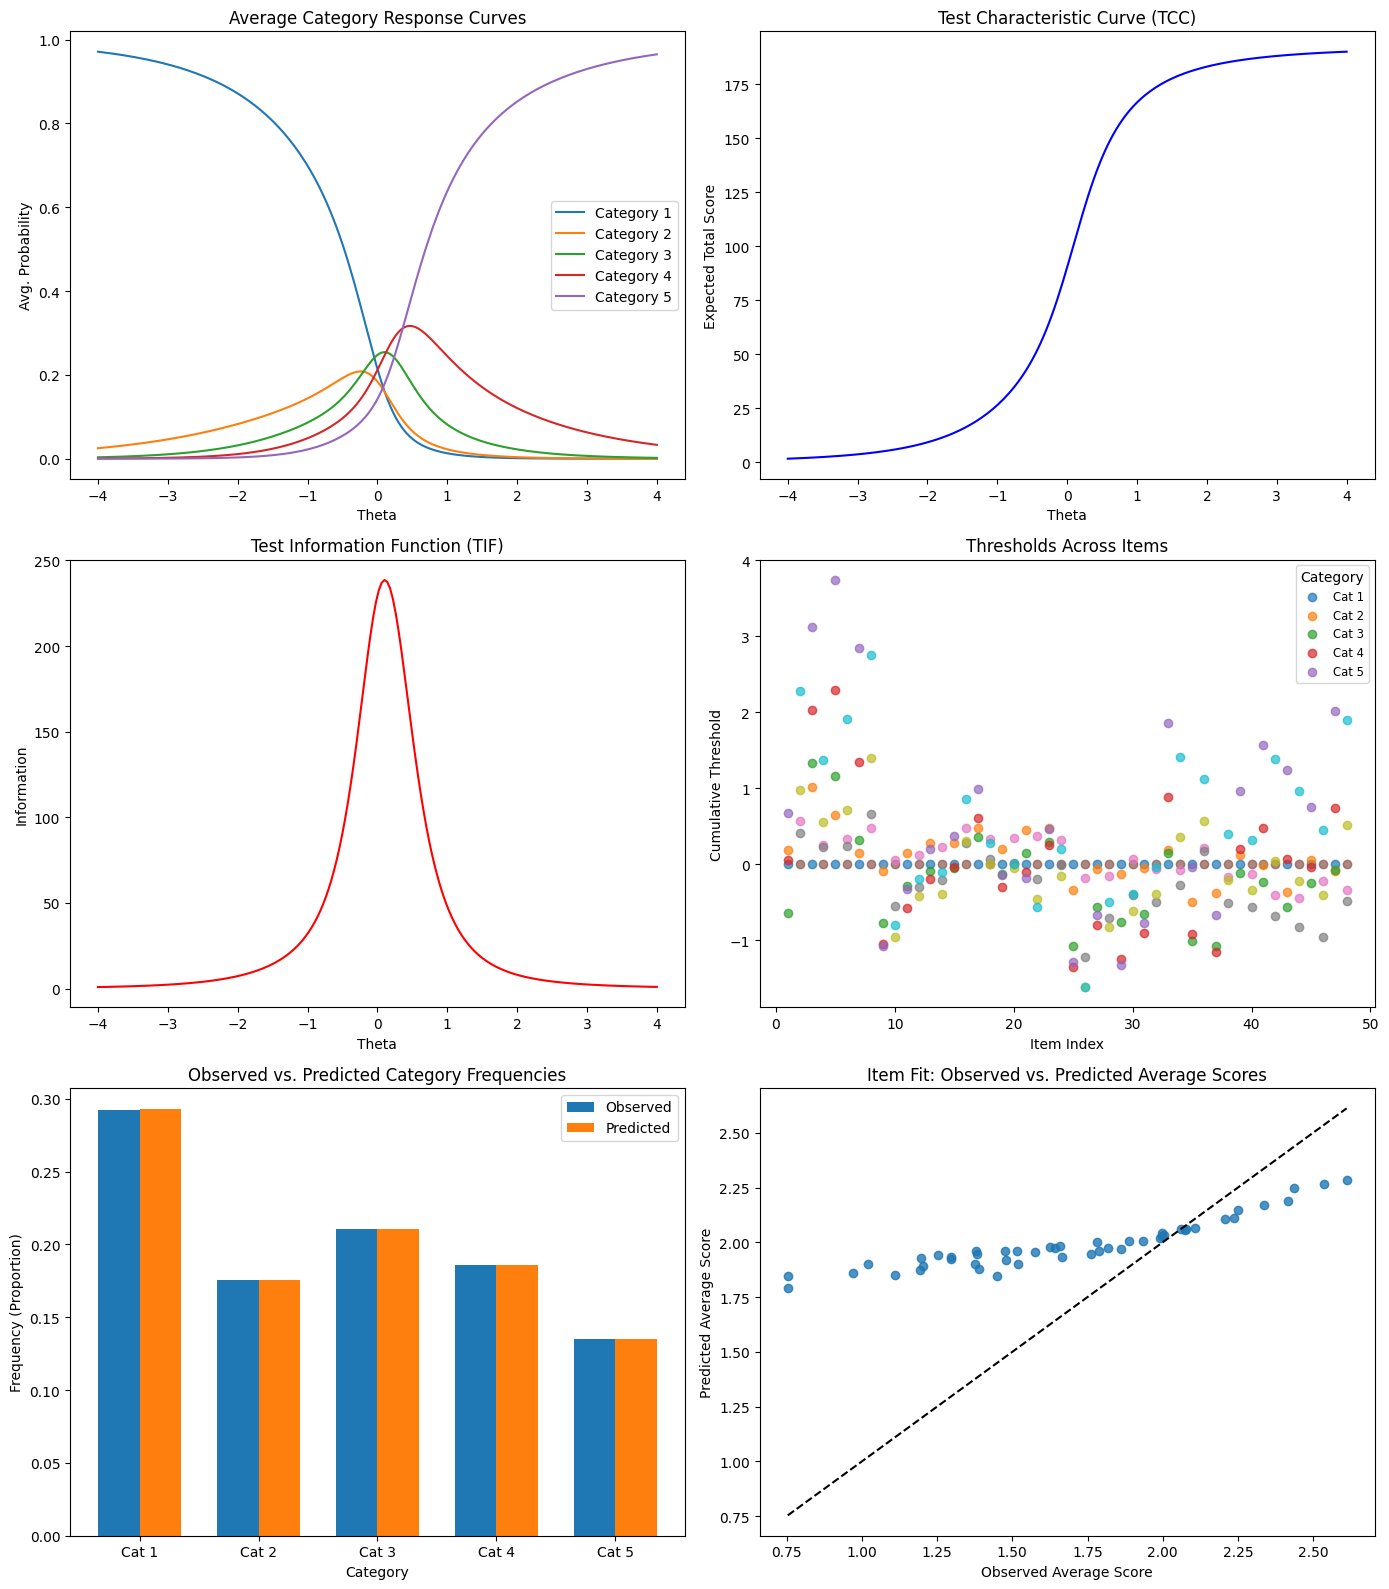

In [130]:
plot_gpcm_diagnostics(model_gpcm, riasec_responses)

In [133]:

plot_single_item_gpcm(
    theta_est=riasec_theta,
    a=riasec_a,
    b=riasec_b,
    observed_item_responses=riasec_responses,
    item_label="Q9R"
    )


ValueError: could not broadcast input array from shape (49,48) into shape (49,)

<Axes: ylabel='Density'>

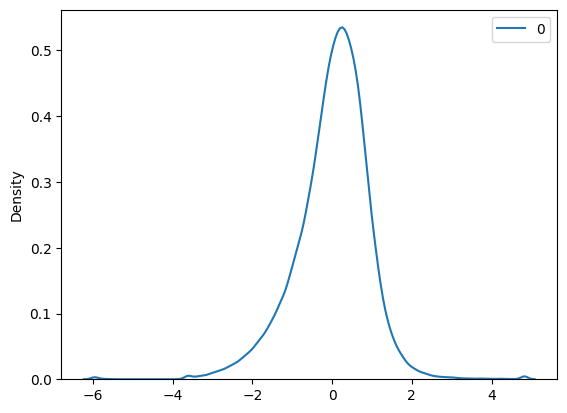

In [77]:
theta_df = pd.read_csv('thetas.csv')
theta_from_df = theta_df.values
sns.kdeplot(theta_from_df)

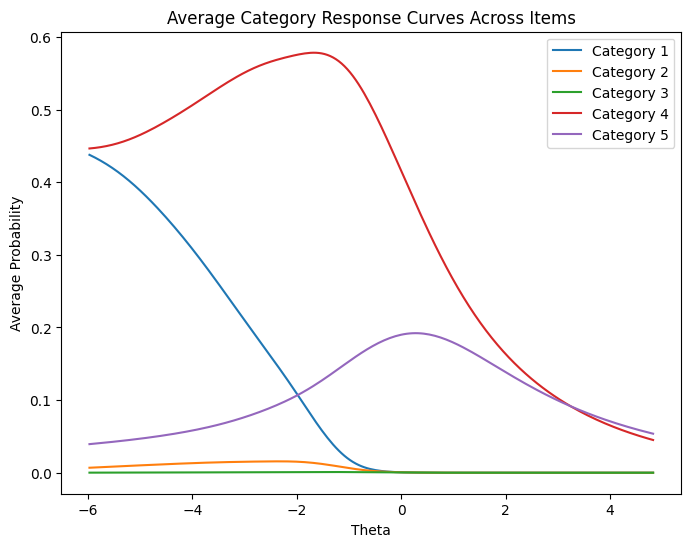

In [126]:
item_pars_df = pd.read_csv('item_pars.csv')
item_pars = item_pars_df.values
a_pars = item_pars[:, 0]
b_pars = item_pars[:, 0:-2]


theta_range = np.linspace(theta_from_df.min(), theta_from_df.max(), 200)

all_probs = np.zeros((n_riasec_items, n_categories+1, len(theta_range)))
for j in range(n_riasec_items):
    cumulative_b = np.concatenate(([0,0], np.cumsum(b_pars[j])))
    for i, theta in enumerate(theta_range):
        # For each category c, compute the score:
        # s(c) = c * (a_pars[j] * theta) - cumulative_b[c]
        s = np.array([c * (a_pars[j] * theta) - cumulative_b[c] for c in range(n_categories+1)])
        # Compute softmax to get probabilities:
        exp_s = np.exp(s - np.max(s))  # subtract max for numerical stability
        p = exp_s / np.sum(exp_s)
        all_probs[j, :, i] = p
        

avg_probs = np.mean(all_probs, axis=0)  # shape: (n_categories, len(theta_range))

# Plot the average category response curves.
plt.figure(figsize=(8, 6))
for c in range(n_categories):
    plt.plot(theta_range, avg_probs[c, :], label=f"Category {c+1}")
plt.xlabel("Theta")
plt.ylabel("Average Probability")
plt.title("Average Category Response Curves Across Items")
plt.legend()
plt.show()

(48, 5)

<Axes: ylabel='Density'>

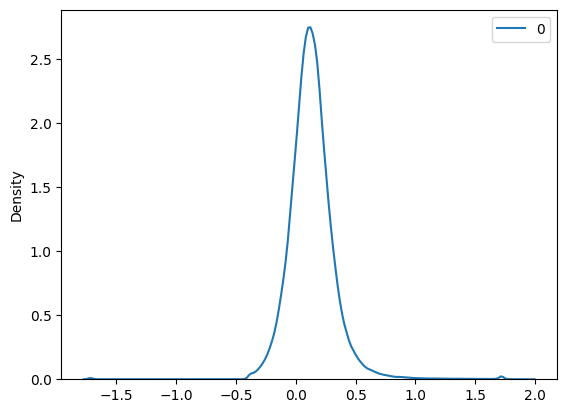

In [81]:
sns.kdeplot(riasec_theta)

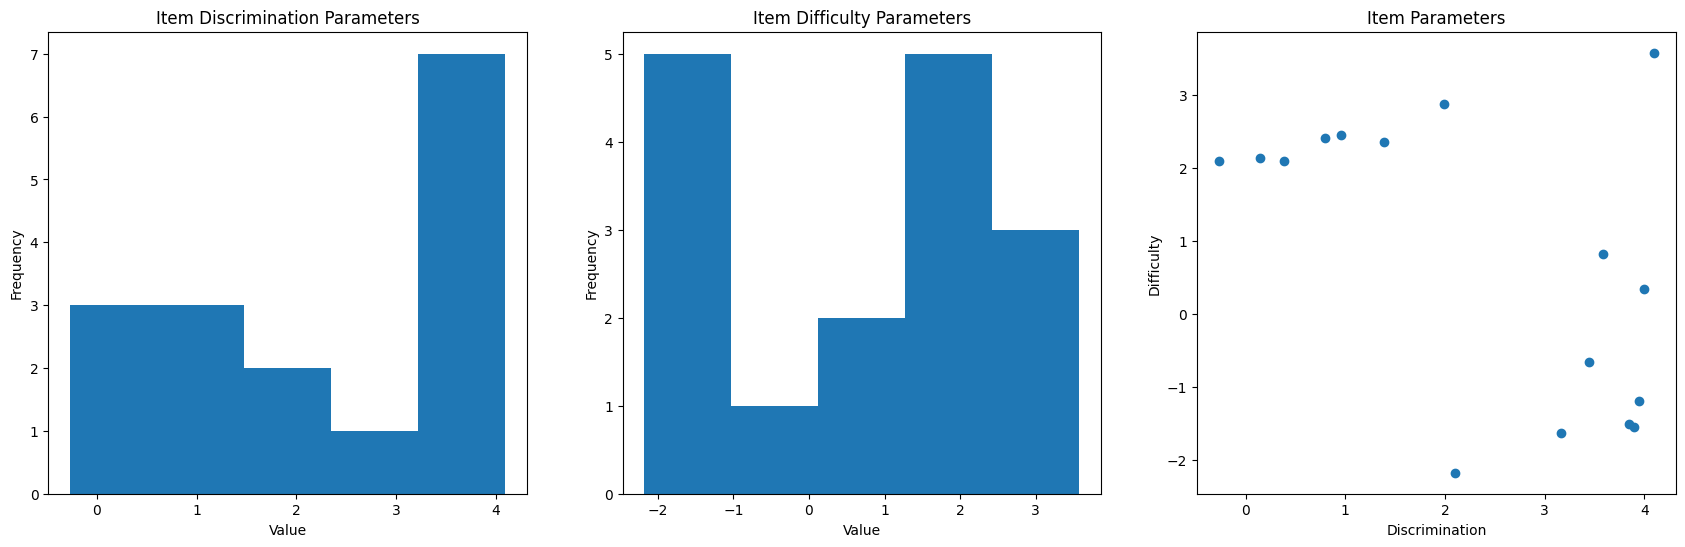

In [163]:
a_params = mirt_model.a.detach().numpy()
b_params = mirt_model.b.detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(21, 6))
ax[0].hist(a_params, bins='auto')
ax[0].set_title('Item Discrimination Parameters')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[1].hist(b_params, bins='auto')
ax[1].set_title('Item Difficulty Parameters')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')
ax[2].scatter(a_params, b_params)
ax[2].set_title('Item Parameters')
ax[2].set_xlabel('Discrimination')
ax[2].set_ylabel('Difficulty')
plt.show()